In [1]:
# pip install pandas
# pip install matplotlib

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from typing import List, Dict, Set, Optional
from dataclasses import dataclass
import random

# 使用 WenQuanYi Zen Hei 作为默认中文字体
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']
plt.rcParams['axes.unicode_minus'] = False  # 避免负号显示问题

In [3]:
@dataclass
class ClarificationNode:
    """澄清节点的数据结构"""
    id: str
    text: str
    aspect: str
    depth: int
    parent_id: Optional[str] = None
    answers: Optional[List[str]] = None

In [4]:
# 2. 知识库数据
def create_knowledge_base() -> Dict:
    """创建知识库"""
    return {
        "abilities": {
            "combat": {
                "physical": ["金刚不坏", "力大无穷", "筋骨如铁"],
                "magical": ["七十二变", "筋斗云", "定身术"],
                "weapon": ["棒法精通", "兵器大师", "法器操控"]
            },
            "perception": {
                "detection": ["火眼金睛", "妖气探查", "气息感知"],
                "insight": ["心性洞察", "破妖辨识", "灵识感应"]
            }
        },
        "relationships": {
            "allies": {
                "disciples": ["红孩儿", "明月", "六耳"],
                "friends": ["杨戬", "哪吒", "龙王三太子"]
            },
            "enemies": {
                "heavenly": ["天兵天将", "二郎神部众"]
            }
        }
    }

In [5]:
# 3. 模板管理
def create_question_templates(character_name: str) -> Dict[str, Dict[str, str]]:
    """创建问题模板"""
    return {
        "abilities": {
            "root": f"您想了解{character_name}的哪类能力？",
            "combat": f"在战斗能力方面，您对{character_name}的哪个方面更感兴趣？",
            "perception": f"关于{character_name}的感知能力，您想了解哪些具体内容？"
        },
        "relationships": {
            "root": f"您想了解{character_name}与谁的关系？",
            "allies": f"在{character_name}的盟友中，您想知道哪类关系？",
            "enemies": f"关于{character_name}的对手，您对哪方势力感兴趣？"
        }
    }

In [6]:
# 4. 问题分析
def identify_main_aspects(question: str) -> Set[str]:
    """识别问题的主要方面"""
    aspects = set()
    keywords = {
        "abilities": ["能力", "本领", "技能", "法术", "神通"],
        "relationships": ["关系", "朋友", "敌人", "师徒", "结交"]
    }
    
    for aspect, words in keywords.items():
        if any(word in question for word in words):
            aspects.add(aspect)
    
    if not aspects:
        aspects.add("abilities")
        
    return aspects

def identify_character(question: str, characters: List[str]) -> Optional[str]:
    """识别问题中提到的角色"""
    for character in characters:
        if character in question:
            return character
    return None

In [7]:
# 5. 树构建
def build_clarification_tree(
    question: str,
    character: str,
    knowledge_base: Dict,
    templates: Dict[str, Dict[str, str]]
) -> nx.DiGraph:
    """构建问题澄清树"""
    G = nx.DiGraph()
    
    # 添加根节点
    root_id = "root"
    G.add_node(root_id, text=question, depth=0)
    
    # 分析问题主题
    main_aspects = identify_main_aspects(question)
    
    # 构建树的各层
    for aspect in main_aspects:
        if aspect not in knowledge_base:
            continue
            
        # 第一层：主要方面
        node_id = f"{aspect}_root"
        G.add_node(node_id, 
                  text=templates[aspect]["root"],
                  depth=1)
        G.add_edge(root_id, node_id)
        
        # 第二层：子方面
        for sub_aspect, sub_data in knowledge_base[aspect].items():
            sub_node_id = f"{aspect}_{sub_aspect}"
            template_text = templates[aspect].get(
                sub_aspect, 
                f"关于{sub_aspect}，您想了解什么？"
            )
            G.add_node(sub_node_id, text=template_text, depth=2)
            G.add_edge(node_id, sub_node_id)
            
            # 第三层：具体内容
            for detail_type, details in sub_data.items():
                detail_node_id = f"{aspect}_{sub_aspect}_{detail_type}"
                detail_text = f"您想了解{detail_type}相关的：{', '.join(details)}？"
                G.add_node(detail_node_id,
                         text=detail_text,
                         depth=3,
                         answers=details)
                G.add_edge(sub_node_id, detail_node_id)
    
    return G

In [8]:
# 6. 可视化
def visualize_tree(G: nx.DiGraph, figsize=(15, 10)):
    """可视化问题澄清树"""
    plt.figure(figsize=figsize)
    
    pos = nx.spring_layout(G, k=2, iterations=50)
    depths = nx.get_node_attributes(G, 'depth')
    colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightpink']
    
    for depth in range(max(depths.values()) + 1):
        nodes_at_depth = [node for node, d in depths.items() if d == depth]
        nx.draw_networkx_nodes(G, pos,
                             nodelist=nodes_at_depth,
                             node_color=colors[depth],
                             node_size=2000)
    
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True)
    labels = nx.get_node_attributes(G, 'text')
    nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight='bold')
    
    plt.title("问题澄清树")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [9]:
# 7. 使用示例
def process_question(question: str):
    """处理问题的完整流程"""
    # 初始化知识库和角色列表
    kb = create_knowledge_base()
    characters = ["孙悟空", "杨戬", "猪八戒"]
    
    # 识别角色
    character = identify_character(question, characters)
    if not character:
        return "未能识别问题中的角色"
    
    # 创建模板
    templates = create_question_templates(character)
    
    # 构建并可视化树
    tree = build_clarification_tree(question, character, kb, templates)
    visualize_tree(tree)
    
    return tree

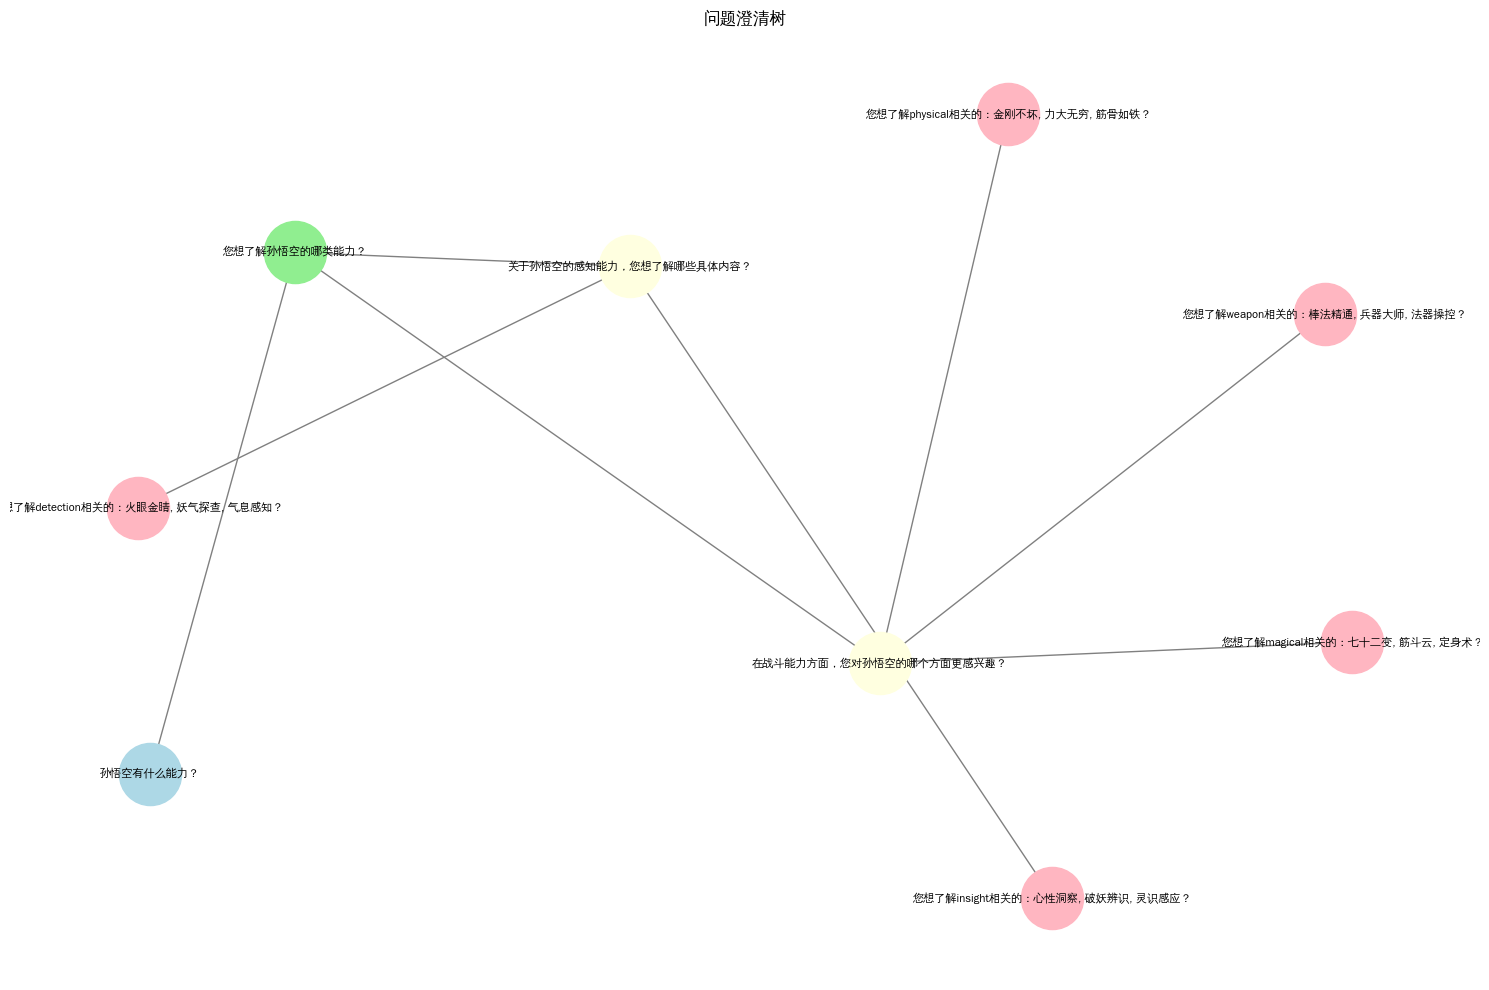

In [10]:
# 简单使用
question = "孙悟空有什么能力？"
tree = process_question(question)

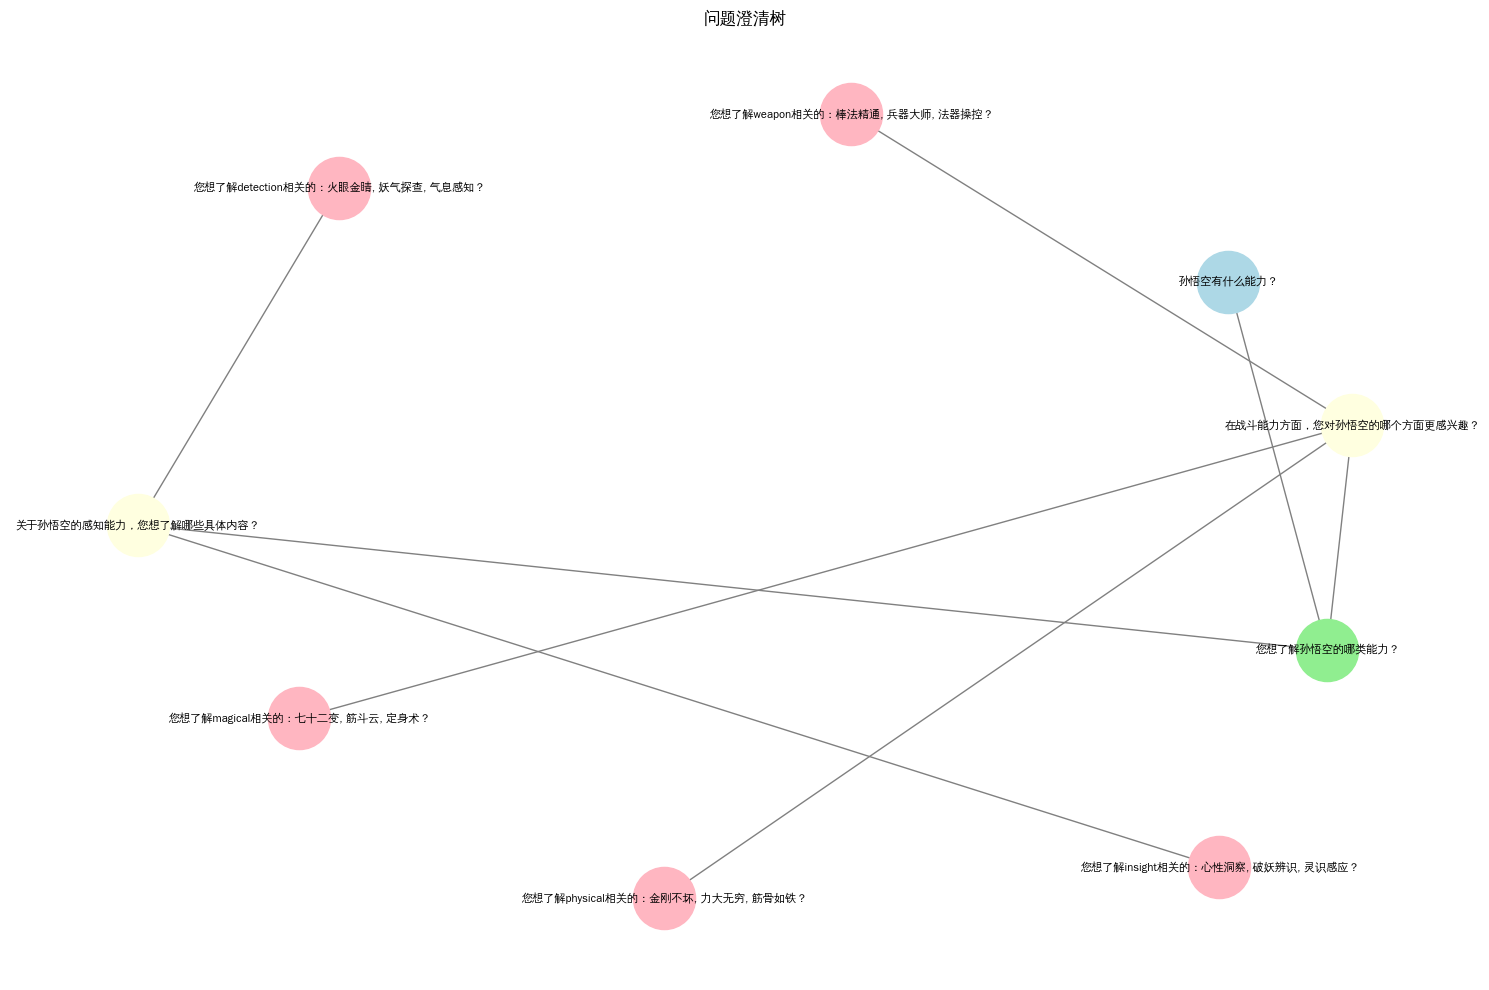

In [11]:
# 或者分步使用
kb = create_knowledge_base()
templates = create_question_templates("孙悟空")
tree = build_clarification_tree(question, "孙悟空", kb, templates)
visualize_tree(tree)